<a href="https://colab.research.google.com/github/IsuruKasun/Machine-Learning-Assignment--03/blob/main/Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [ ]:
!pip install skfeature-chappers
!pip install scikit-learn

import pandas as pd
from matplotlib.pyplot import bar, xlabel, ylabel, title
import matplotlib.pyplot as plt
from google.colab import drive

from sklearn.model_selection  import train_test_split
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 1.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount drive for dataset import

drive.mount('/content/drive')

dbPath = '/content/drive/MyDrive/SYSC4415W23_A3_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Sample to labels csv dataset to pandas dataframe
labels = pd.read_csv(dbPath + "/train/labels.csv")

test_labels = pd.read_csv(dbPath + "/test/labels.csv")
'''
# Dictionary to store sample and its associated pandas dataframe
# {key:value} = {sample id:pandas dataframe}
signals = {}

for sample_id in labels["sample_id"]:

  signals[sample_id] = pd.read_csv(dbPath + "/train/signals/" + str(sample_id) + ".csv")
'''
print(labels.shape)
print(test_labels.shape)

In [ ]:
# Import the train and test datasets

features = pd.read_csv(dbPath + "/train/extracted_features.csv")

test_df = pd.read_csv(dbPath + "/test/extracted_features.csv")

test_column_order = test_df['sample_id']

test_df.insert(1, 'label', "")

print(features.shape)
print(test_df.shape)

In [ ]:
# Creates a merged dataframe from the features and its associated label
df = pd.merge(labels, features, on='sample_id')

df_columns = df.columns

print(df.shape)

# Data Cleanup

In [ ]:
# Remove  quasi-constant features (90 % similarity)

qconstant_filter = VarianceThreshold(threshold=0.10)

qconstant_filter.fit(df)

qconstant_columns = [column for column in df.columns
                    if column not in df.columns[qconstant_filter.get_support()]]

print("Number of quasi-constant features: " + str(len(qconstant_columns)))

df = df[df.columns[qconstant_filter.get_support(indices=True)]]

print(df.shape)

# Remove sample_id column & NaN columns
df = df.drop(['sample_id'], axis=1)
df = df.dropna(axis=1)

print(df.shape)

train, val = train_test_split(df, test_size=0.2)

In [ ]:
# Test data cleanup 
test_df = test_df[test_df.columns[qconstant_filter.get_support(indices=True)]]

test_df = test_df.drop(['sample_id', 'label'], axis=1)
test_df = test_df.dropna(axis=1)

print(test_df.shape)

In [ ]:
Y_tr = train['label']
X_tr = train[train.columns.drop(['label'])]

Y_val = val['label']
X_val = val[val.columns.drop(['label'])]

# Copy the data
X_tr_scaled = X_tr.copy()
X_val_scaled = X_val.copy()

# Apply normalization
for column in X_tr_scaled.columns:
	X_tr_scaled[column] = (X_tr_scaled[column] - X_tr_scaled[column].min()) / (X_tr_scaled[column].max() - X_tr_scaled[column].min())	
 
for column in X_val_scaled.columns:
	X_val_scaled[column] = (X_val_scaled[column] - X_val_scaled[column].min()) / (X_val_scaled[column].max() - X_val_scaled[column].min())	

print(X_tr_scaled.shape)
print(X_val_scaled.shape)

In [ ]:
# Copy the data
X_test_scaled = test_df.copy()

# Apply normalization
for column in X_test_scaled.columns:
	X_test_scaled[column] = (X_test_scaled[column] - X_test_scaled[column].min()) / (X_test_scaled[column].max() - X_test_scaled[column].min())	
 
print(X_tr_scaled.shape)

In [ ]:
# # Finding ideal value for k for logistic regression based on ANOVA score

from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

fs = SelectKBest(score_func=f_classif, k='all')

fs.fit(X_tr_scaled, Y_tr)
cols_idxs = fs.get_support(indices=True)

X_best_features = X_tr_scaled.iloc[:,cols_idxs]

X_best_features_val = X_val_scaled.iloc[:,cols_idxs]

index = []

for i in range(len(fs.scores_)):
  #print('Feature %d: %f' % (i, fs.scores_[i]))
  if fs.scores_[i] < 100:
    index.append(i)

X_best_features2 = X_best_features.drop(X_best_features.columns[index], axis=1)
X_best_features_val2 = X_best_features_val.drop(X_best_features_val.columns[index], axis=1)

print(index) 
print(len(index)) 

print(X_best_features.shape)
print(X_best_features_val.shape)

print(X_best_features2.shape)
print(X_best_features_val2.shape)

In [ ]:
X_best_features_test = X_test_scaled.drop(X_test_scaled.columns[index], axis=1)

print(X_best_features_test.shape)

(287, 1196)


# Model Training

In [ ]:
# XGBoost Model

xModel = XGBClassifier(max_depth=5).fit(X_best_features2, Y_tr)

accTrain = accuracy_score(Y_tr, xModel.predict(X_best_features2))
print("Accuracy of training set: " + str(accTrain))

accVal = accuracy_score(Y_val, xModel.predict(X_best_features_val2))
print("Accuracy of validation set: " + str(accVal))

# Model 2 Training

In [ ]:
rf = RandomForestClassifier(n_estimators=800, random_state=50)

rf.fit(X_best_features2, Y_tr)

#y_pred_train = rf.predict(X_best_features)

accTrain = accuracy_score(Y_tr, rf.predict(X_best_features2))
print("Accuracy of training set: " + str(accTrain))

accVal = accuracy_score(Y_val, rf.predict(X_best_features_val2))
print("Accuracy of validation set: " + str(accVal))

Accuracy of training set: 0.9992283950617284
Accuracy of validation set: 0.6030769230769231


# Model 3 Training

In [ ]:
#scalar.fit(X_best_features2)
svm_model = svm.SVC(kernel='linear')

svm_model.fit(X_best_features2, Y_tr)

accTrain = accuracy_score(Y_tr, svm_model.predict(X_best_features2))
print("Accuracy of training set: " + str(accTrain))

accVal = accuracy_score(Y_val, svm_model.predict(X_best_features_val2))
print("Accuracy of validation set: " + str(accVal))

Accuracy of training set: 0.8618827160493827
Accuracy of validation set: 0.6892307692307692


# Model 4 Training

In [ ]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(max_iter=5000).fit(X_best_features2, Y_tr)

accTrain = accuracy_score(Y_tr, LR_model.predict(X_best_features2))
print("Accuracy of training set: " + str(accTrain))

accVal = accuracy_score(Y_val, LR_model.predict(X_best_features_val2))
print("Accuracy of validation set: " + str(accVal))

# Model Combining

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[('xgb', xModel), ('rf', rf), ('svm', svm_model), ('lr', LR_model)])

voting_model.fit(X_best_features2, Y_tr)

accTrain = accuracy_score(Y_tr, voting_model.predict(X_best_features2))
print("Accuracy of training set: " + str(accTrain))

accVal = accuracy_score(Y_val, voting_model.predict(X_best_features_val2))
print("Accuracy of validation set: " + str(accVal))

# Model Prediction

In [ ]:
y_pred = voting_model.predict(X_best_features_test)

In [ ]:
csv_out = pd.DataFrame({'sample_id': test_column_order, 'predicted_labels': y_pred})

csv_out.to_csv(dbPath + '/14_predictions.csv', index=False)

# Model Accuracy

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(voting_model, X_best_features_val2, Y_val, cv=5)

In [ ]:
std_dev = np.std(cv_scores)
print(std_dev)

std_out = pd.DataFrame({'accuracy': accVal, 'accuracy std': std_dev}, index=[0])

std_out.to_csv(dbPath + '/14_predicted_performace.csv', index=False)

Confusing Matrix

In [ ]:
# Make predictions on validation set
y_val_pred = xModel.predict(X_best_features_val2)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_val, y_val_pred)
print(cm)

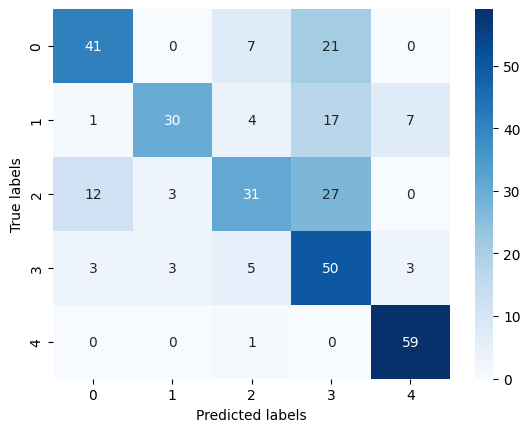

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

PR - Curve

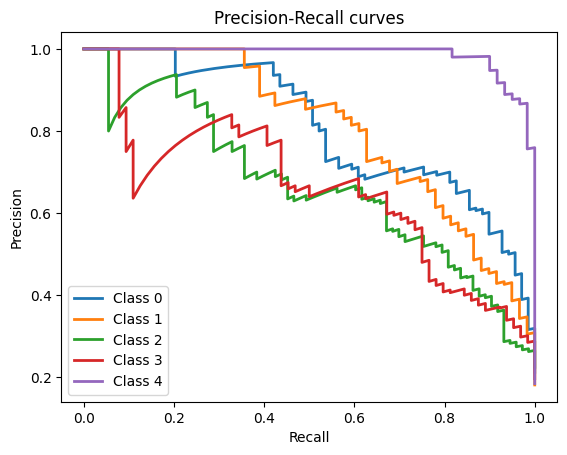

In [ ]:
# Predict class probabilities for test set
probs = xModel.predict_proba(X_best_features_val2)

# Compute precision, recall, and threshold values for each class
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
threshold = dict()

for i in range(xModel.n_classes_):
    precision[i], recall[i], threshold[i] = precision_recall_curve(
        Y_val == i, probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')

# Plot PR curves
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.title('Precision-Recall curves')
plt.show()